In [ ]:
##LSTM

In [ ]:
!pip install fastai==1.0.61
!pip install ipdb

In [ ]:
import math
import torch
import torch.nn as nn

In [ ]:
class NLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):

    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    #forget gate

    self.U_f = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.V_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_f = nn.Parameter(torch.Tensor(hidden_size))

    #input gate

    self.U_i = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.V_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_i = nn.Parameter(torch.Tensor(hidden_size))

    #Ct+ gate

    self.U_c = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.V_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_c = nn.Parameter(torch.Tensor(hidden_size))

    #output gate

    self.U_o = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.V_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_o = nn.Parameter(torch.Tensor(hidden_size))

    self.init_weights()
  
  def init_weights(self):

    stdev = 1/math.sqrt(self.hidden_size)
    for i in self.parameters():
      i.data.uniform_(-stdev, stdev)
  
  def forward(self, x, init_states = None):

    # x - batch_size*seq_length(length of the sentence)*feature_length(length of embedding)
    # init states is an array

    bs, seq_length, emb_size = x.size()

    if not init_states:
      c_t, h_t = torch.zeros(bs, self.hidden_size), torch.zeros(bs, self.hidden_size)
    
    else:
      c_t, h_t = init_states

    hidden_seqs = []
    for t in range(seq_length):

      x_t = x[:, t, :]

      f_t = torch.sigmoid(x_t@self.U_f + h_t@self.V_f + self.b_f)
      i_t = torch.sigmoid(x_t@self.U_i + h_t@self.V_i + self.b_i)
      g_t = torch.tanh(x_t@self.U_c + h_t@self.V_c + self.b_c)
      o_t = torch.sigmoid(x_t@self.U_o + h_t@self.V_o + self.b_o)

      c_t = f_t*c_t + i_t*g_t
      h_t = o_t * torch.tanh(c_t)
      hidden_seqs.append(h_t)
    
    return hidden_seqs, [c_t, h_t]      

In [ ]:
from fastai import *
from fastai.text import *
import numpy as np
from ipdb import set_trace as st
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import nltk
# nltk.download('all-nltk')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords

In [ ]:
english_stop_words = stopwords.words('english')

In [ ]:
include_stop_words = ['but','if','or','until','while','against','between','before','after','above','below','up','down','over','under','between','again','further','when','where','why','how','all','any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very','don', "don't", 'should', "should've", 'now','ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'just','out','through']

In [ ]:
domain_specific_stop_words = list(set(english_stop_words) - set(include_stop_words))

In [ ]:
pos_reviews = []
neg_reviews = []

mp = untar_data(URLs.IMDB)

from string import punctuation
import re

def get_all_reviews(path_obj):
  arr = []
  CLEANR = re.compile('<.*?>') 
  for i in path_obj.ls():
    with open(i, 'r') as f:
      x = f.read().lower()
      x = re.sub(CLEANR, '', x)
      arr.append(''.join([c for c in x if c not in punctuation]))
  return arr

def get_all_reviews_with_punc(path_obj):
  arr = []
  CLEANR = re.compile('<.*?>') 
  for i in path_obj.ls():
    with open(i, 'r') as f:
      x = f.read()#.lower()
      x = re.sub(CLEANR, '', x)
      # arr.append(''.join([c for c in x if c not in punctuation]))
      arr.append(x)
  return arr

# use get all reviews with punc if we are using nltk pre processing stuff

pos_reviews = get_all_reviews(mp/'train/pos')
neg_reviews = get_all_reviews(mp/'train/neg')
combined = pos_reviews + neg_reviews

In [ ]:
combined[:3]

['and my children love it now granted i can watch it now and realize the animation wasnt that great and that the plot is trite hey if every villian introduced themselves by saying i ammmmm daaaarrrkk heeeeaaarrt i think they might be laughed at but for young children it is a moral story with catchy musicmusic so catchy mind you that i still had the words memorized after not seeing this film in twenty years i would definitely suggest this one for younger children',
 'a charming funny film that gets a solid grade all around i saw a screener of this film recently at work it was so nice to see this film in contrast with all the crappy horror movies i see every day so much so that i figured id write in not sure if this film is going to theaters but i hope it does its a nice film to see with friends its a charmer and has some funny jokes the acting was terrific especially howard hessman and larry dorf the directing was pretty good not a film that needed to be overdirected what really makes t

In [ ]:
# Data Preprocessing pipeline 
# Define a class and have one main method to process all the data and return a new updates string

# step 1 - tokenize words using word tokenizer
# step 2 - Lemmatize using wordnet lemmatizer
# step 3 - Pos Tagging
# step 4 - Replacing all named entities with NE
# setp 5 - Replacing all the punctuations
# step 6 - Convert to lower case

class DataPreProcessing:
  def __init__(self, data_array):
    self.data_array = data_array
    self.wnl = WordNetLemmatizer()
    self.stop_words = domain_specific_stop_words
  
  def tokenize(self, text):
    return word_tokenize(text)
  
  def lemmatize_text_list(self, words):
    return [self.wnl.lemmatize(w) for w in words]
  
  def pos_tag_words(self, words):
    # st()
    return pos_tag(words)
 
  def replace_in_sentence(self, word_tags, replace_tag = 'NNP', replace_by = 'NE'):

    for i in range (len(word_tags)):
      # i is a tuple
      th = word_tags[i]

      if th[1] == replace_tag:
        th = list(th)
        th[0] = replace_by
        word_tags[i] = tuple(th) 
    
    return word_tags
  
  def remove_punctuation(self, tagged_words):
    return [c for c in tagged_words if c[0] not in punctuation]
  
  def replace_names_remove_punct_lower(self, tagged_words, replace_tag = 'NNP', replace_by = 'NE'):
    new = []
    for i in tagged_words:
      i = list(i)

      if i[0] in punctuation:
        continue

      i[0] = i[0].lower()
      if i[1] == replace_tag:
        i[0] = replace_by

      new.append(i[0])
    return new
      
      
  def forward_sentence(self, text):
    tagged = self.pos_tag_words(self.lemmatize_text_list(self.tokenize(text)))
    c2 = self.replace_names_remove_punct_lower(tagged)
    return c2
  
  def forward_all(self):
    return [self.forward_sentence(i) for i in self.data_array]

  def remove_stop_words(self, text):
    return ' '.join([word for word in text.split() if word not in self.stop_words])

dp = DataPreProcessing(combined)

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
processed_combined = dp.forward_all()

In [ ]:
len(processed_combined)

25000

In [ ]:
# if using NLTK parsing
all_text2 = ''
for i in processed_combined:
  this_text = ' '.join(j for j in i)
  all_text2 += this_text + ' '

In [ ]:
#without NLTK parsing
all_text2 = ' '.join(i for i in combined)

In [ ]:
lables = [1.0 for i in range(len(pos_reviews))] + [0.0 for j in range(len(neg_reviews))]

from collections import Counter

words = all_text2.split()
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(70000)

vocab_to_int = {w: (i + 1) for i, (w,c) in enumerate(sorted_words)}
vocab_to_int['UNK'] = 70001

int_to_vocab = {}
for i in vocab_to_int:
  int_to_vocab[vocab_to_int[i]] = i

encoded_revs = []
for rev in combined:
  t_rev = []
  for word in rev.split():
    if word in vocab_to_int:
      t_rev.append(vocab_to_int[word])
    else:
      t_rev.append(vocab_to_int['UNK'])
  encoded_revs.append(t_rev)

def get_rev_string(int_rev):
  return ' '.join(int_to_vocab[i] for i in int_rev)

encoded_labels = np.array(lables)

In [ ]:
total_words

5722753

In [ ]:
sorted_words[:50]

In [ ]:
len(sorted_words)

70000

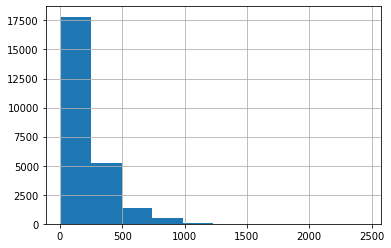

In [ ]:
lens = [len(r) for r in encoded_revs]
pd.Series(lens).hist()
plt.show()

In [ ]:
pd.Series(lens).describe()

count    25000.00000
mean       228.83248
std        170.02192
min         10.00000
25%        125.00000
50%        171.00000
75%        278.00000
max       2450.00000
dtype: float64

In [ ]:
seq_len = 278
def pad_revs(encoded_revs = encoded_revs, seq_len = seq_len):
  features = np.zeros([len(encoded_revs), seq_len], dtype=int)
  for i, rev in enumerate(encoded_revs):
    # if the review len is less than seq_len, than suffix it with 0
    # if the review len is greater than seq_len then slice it till seq_len
    
    if len(rev) < seq_len:
      this_rev = np.array(list(np.zeros((seq_len - len(rev)), dtype = int)) + rev)
    else:
      this_rev = np.array(rev[:seq_len])

    assert len(this_rev) == seq_len
    features[i] = this_rev
  return features

features = pad_revs()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
batch_size = 128

In [ ]:
encoded_labels = encoded_labels.astype(int)

X = torch.from_numpy(features)
y = torch.from_numpy(encoded_labels)

dataset = TensorDataset(X, y)

train_set, valid_set = random_split(dataset, [20000, 5000])
train_sampler = SubsetRandomSampler(train_set.indices)
valid_sampler = SubsetRandomSampler(valid_set.indices)

train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
valid_loader = DataLoader(dataset, batch_size = batch_size, sampler = valid_sampler)

train_iter = iter(train_loader)
sx, sy = next(train_iter)


In [ ]:
from torch.nn.modules import dropout
class classificationLSTM(nn.Module):
  def __init__(self, vocab_size, emb_dim, hidden_size, num_layers, num_outputs, bs, dropout = 0.3, emb_dropout = 0.3, bi_directional = False):
    super().__init__()
    
    self.bs = bs
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.vocab_size = vocab_size
    self.embs = nn.Embedding(num_embeddings = vocab_size, embedding_dim = emb_dim)
    self.dropout = nn.Dropout(p = emb_dropout)
    self.lstm = nn.LSTM(input_size = emb_dim, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout, batch_first = True, bias = True, bidirectional = bi_directional)

    self.D = 2 if bi_directional else 1
    
    self.out_layer = nn.Sequential(nn.Linear(hidden_size * self.D, hidden_size//2, bias = True), nn.ReLU(), nn.BatchNorm1d(hidden_size//2), nn.Linear(hidden_size//2, num_outputs, bias = True), nn.BatchNorm1d(num_outputs), nn.LogSoftmax(dim = 1))

    self.init_weights()
  
  def init_weights_old(self):

    stdev = 1/math.sqrt(self.hidden_size)
    for i in self.parameters():
      i.data.uniform_(-stdev, stdev)
  
  def forward(self, x, hidden):
    # st()
    bs = x.shape[0]
    embs = self.dropout(self.embs(x))
    lstm_out, hidden = self.lstm(embs, hidden)
    lstm_out = lstm_out[:, -1, :]
    # st()
    out = self.out_layer(lstm_out)
    # out = out[:, -1]
    return out, hidden
  
  def init_weights(self):

    # stdev = 1/math.sqrt(self.hidden_size)
    for i in self.parameters():
      if (len(i.shape) != 1 and i.shape[0] != vocab_size):
        std_dev = math.sqrt(2/i.shape[1])
        i.data.uniform_(-std_dev, std_dev)
      elif (len(i.shape) == 1):
        std_dev = math.sqrt(2/i.shape[0])
        i.data.uniform_(-std_dev, std_dev)

  def init_hidden(self):
    weight = next(self.parameters()).data

    hidden = (weight.new(self.D*self.num_layers, self.bs, self.hidden_size).zero_().cuda(),
              weight.new(self.D*self.num_layers, self.bs, self.hidden_size).zero_().cuda())

    return hidden

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [ ]:
class ClassificationTransformer(nn.Module):

    def __init__(self, vocab_size = 70002, d_model = 400, nhead = 8, dim_feedforward = 2048, num_layers = 6, emb_dropout = 0.1, activation = "relu", dropout = 0.1, seq_len = 278):

        super().__init__()

        # vocab_size, d_model = embeddings.size()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model = d_model, dropout = emb_dropout, vocab_size = vocab_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = nhead, dim_feedforward = dim_feedforward, dropout = dropout, batch_first = True)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers = num_layers,
        )
        
        self.lin1 = nn.Linear(400, 1)
        self.bn1 = nn.BatchNorm1d(400)

        self.final_layer = nn.Sequential(nn.Linear(seq_len, seq_len//2), nn.ReLU(), nn.BatchNorm1d(seq_len//2), nn.Linear(seq_len//2, 2), nn.BatchNorm1d(2), nn.LogSoftmax(dim = 1))
        self.d_model = d_model

    def forward(self, x):
        embs = self.emb(x)
        pos_encs = self.pos_encoder(embs)
        encs = self.transformer_encoder(pos_encs)
        
        l1 = self.lin1(encs)
        l1 = l1.view(-1, 278)

        return self.final_layer(l1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
sx = sx.to(device)
sy = sy.to(device)
# Transformer = Transformer.to(device)

In [ ]:
vocab_size = 70002
emb_dim = 400
hidden_size = 256
num_layers = 2
num_outputs = 2
bs = batch_size

# LSTM = classificationLSTM(vocab_size, emb_dim, hidden_size, num_layers, num_outputs, bs, dropout = 0.5, emb_dropout = 0.5, bi_directional = False)

Transformer = ClassificationTransformer(emb_dropout = 0.3, dropout = 0.3, num_layers = 4).to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# optimizer = optim.Adagrad(Transformer.parameters(),lr = 0.001)
loss_func_internal = nn.NLLLoss()

def loss_func(yhat, y, loss_func_internal = loss_func_internal):
  return loss_func_internal(yhat, y)

def accuracy(yhat, y):
  preds = yhat.argmax(dim = 1)
  return float(torch.sum(preds == y)/y.shape[0])

def train(train_loader = train_loader, valid_loader = valid_loader, net = Transformer, optimizer = optimizer, loss_func = loss_func, device = device, epochs = 4, hiddens = None):
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []
  if (not hiddens) and (net.__class__ == classificationLSTM):
    hiddens = net.init_hidden()

  for i in range(epochs):
    # if (i > 4):
    #   optimizer.lr = 5e-04
    net = net.to(device)
    net.train()
    
    for x, y in iter(train_loader):
      # step 1 convert everything to cuda
      # x = torch.LongTensor(x)
      try:

        if (x.shape[0] != bs):
          continue
        # st()
        x = x.to(device)
        y = y.to(device)

        if (net.__class__ == classificationLSTM):
          hiddens = net.init_hidden()
          hiddens = tuple([each.data for each in hiddens])
          yhat, hiddens = net(x, hiddens)
        else:
          yhat = net(x)
        
        net.zero_grad()
        loss = loss_func(yhat, y)
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), 5)
        
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(yhat, y))
        if (i > 0):
          valid_losses.append(valid_losses[-1])
          valid_accs.append(valid_accs[-1])
        if (len(train_losses)%100 == 0):
          print(np.mean(train_losses[-5:]), np.mean(train_accs[-5:]))

      except Exception as execp: 
        st() 
        print(execp)
        

    net.eval()
    for vx, vy in iter(valid_loader):
      # vx = torch.LongTensor(vx)
      vx = vx.to(device)
      vy = vy.to(device)

      if (vx.shape[0] != bs):
        continue

      if (net.__class__ == classificationLSTM):
        hiddens = net.init_hidden()
        hiddens = tuple([each.data for each in hiddens])
        vyhat, hiddens = net(vx, hiddens)
      else:
        vyhat = net(vx)

      loss = loss_func(vyhat, vy)
      valid_accs.append(accuracy(vyhat, vy))
      valid_losses.append(loss.item())

      train_losses.append(train_losses[-1])
      train_accs.append(train_accs[-1])

      if (len(valid_losses)%50 == 0):
        print("Valid Loss ", np.mean(valid_losses[-10:]), np.mean(valid_accs[-10:]))
  
  return train_losses, valid_losses, train_accs, valid_accs, hiddens, net

In [ ]:
optimizer = torch.optim.Adam(Transformer.parameters(), lr = 1e-04) 
tl, vl, ta, va, hiddens, net = train(epochs = 4, optimizer = optimizer)

0.6923726320266723 0.5125
0.6904108166694641 0.534375
0.5456638216972352 0.7296875
Valid Loss  0.5808667421340943 0.65390625
0.4839463472366333 0.775
0.40760899186134336 0.8125
Valid Loss  0.4325030893087387 0.8078125
0.39348621368408204 0.8390625
0.40511520504951476 0.803125
Valid Loss  0.3819982558488846 0.8265625


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-04)
tl2, vl2, ta2, va2, hiddens, net2 = train(net = net, optimizer = optimizer, epochs = 4, hiddens = hiddens)

0.40033088326454164 0.821875
0.35909292101860046 0.8359375
0.3553101599216461 0.85
Valid Loss  0.34610015749931333 0.85234375
0.3445954561233521 0.8671875
0.3481219530105591 0.8546875
Valid Loss  0.3471935302019119 0.8484375
0.33612256646156313 0.875
0.3046099364757538 0.878125
Valid Loss  0.3629705309867859 0.84375


In [ ]:
optimizer = torch.optim.Adam(net2.parameters(), lr = 6e-05)
tl3, vl3, ta3, va3, hiddens, net3 = train(net = net2, optimizer = optimizer, epochs = 4, hiddens = hiddens)

0.3134920120239258 0.8734375
0.3385751247406006 0.85
0.30034512281417847 0.86875
Valid Loss  0.428901281952858 0.81171875
0.2665764629840851 0.8921875
0.2827612280845642 0.8921875
Valid Loss  0.357012003660202 0.859375
0.27137553989887236 0.903125
0.2892747104167938 0.89375
Valid Loss  0.364293572306633 0.8578125


In [ ]:
optimizer = torch.optim.Adam(net3.parameters(), lr = 5e-05)
tl4, vl4, ta4, va4, hiddens, net4 = train(net = net3, optimizer = optimizer, epochs = 8, hiddens = hiddens)

0.27630676329135895 0.9015625
0.2601646214723587 0.9
0.292568764090538 0.88125
Valid Loss  0.39767503142356875 0.846875
0.2677645593881607 0.8921875
0.282728773355484 0.896875
Valid Loss  0.3767939567565918 0.8578125
0.25847980082035066 0.903125
0.278619384765625 0.896875
Valid Loss  0.36913852095603944 0.84921875
0.26706956923007963 0.9046875
0.2573092460632324 0.8984375
Valid Loss  0.36397494077682496 0.8515625
0.25141836106777193 0.909375
0.2696866601705551 0.896875
Valid Loss  0.34168110489845277 0.8671875
0.2801853656768799 0.878125
0.23612163662910463 0.91875
Valid Loss  0.35704878270626067 0.86015625
0.26077521443367 0.903125
0.25806422233581544 0.8984375
Valid Loss  0.33687775284051896 0.86484375


In [ ]:
optimizer = torch.optim.Adam(net4.parameters(), lr = 1e-05)
tl5, vl5, ta5, va5, hiddens, net5 = train(net = net4, optimizer = optimizer, epochs = 4, hiddens = hiddens)

0.22919915616512299 0.925
0.18906308114528655 0.9390625
0.2785822212696075 0.89375
Valid Loss  0.3609338641166687 0.88203125
0.2257683753967285 0.9265625
0.23262809514999389 0.9234375
Valid Loss  0.40727649331092836 0.85546875
0.21252832412719727 0.9234375
0.22596641182899474 0.9234375
Valid Loss  0.341300331056118 0.8734375


In [ ]:
from copy import deepcopy
net_saved = deepcopy(net5)

In [ ]:
optimizer = torch.optim.Adam(net5.parameters(), lr = 1e-04)
tl6, vl6, ta6, va6, hiddens, net6 = train(net = net5, optimizer = optimizer, epochs = 1, hiddens = hiddens)

0.25565778017044066 0.89375


In [ ]:
net_saved_1 = deepcopy(net6)

In [ ]:
optimizer = torch.optim.Adam(net6.parameters(), lr = 1e-05)
tl7, vl7, ta7, va7, hiddens, net7 = train(net = net6, optimizer = optimizer, epochs = 7, hiddens = hiddens)

0.22430045902729034 0.90625
0.2451213300228119 0.9
0.22160124480724336 0.91875
Valid Loss  0.3937703654170036 0.84765625
0.22033201456069945 0.91875
0.24096328914165496 0.9140625
Valid Loss  0.39466664642095567 0.85
0.2227683484554291 0.91875
0.23645130097866057 0.909375
Valid Loss  0.3786997675895691 0.865625
0.21502493023872377 0.9234375
0.23730385601520537 0.921875
Valid Loss  0.38697117269039155 0.8609375
0.22905005812644957 0.921875
0.22561399042606353 0.921875
Valid Loss  0.3965780109167099 0.859375
0.20602967739105224 0.9296875
0.17655081152915955 0.9453125
Valid Loss  0.37664999812841415 0.87109375


In [ ]:
optimizer = torch.optim.Adam(net7.parameters(), lr = 1e-04)
tl8, vl8, ta8, va8, hiddens, net8 = train(net = net7, optimizer = optimizer, epochs = 3, hiddens = hiddens)

0.24197150766849518 0.9125
0.21095925867557525 0.9359375
0.26488845646381376 0.8953125
Valid Loss  0.3138933777809143 0.884375
0.21487709283828735 0.9265625
0.22656959891319275 0.90625
Valid Loss  0.3497843623161316 0.871875


In [ ]:
optimizer = torch.optim.Adam(net8.parameters(), lr = 8e-05)
tl9, vl9, ta9, va9, hiddens, net9 = train(net = net8, optimizer = optimizer, epochs = 7, hiddens = hiddens)

0.21719134747982025 0.91875
0.20647062361240387 0.934375
0.19372345507144928 0.9375
Valid Loss  0.4420066103339195 0.84375
0.22228778004646302 0.9234375
0.21144105195999147 0.9234375
Valid Loss  0.37563740611076357 0.86015625
0.1927757143974304 0.9390625
0.18359166979789734 0.9421875
Valid Loss  0.35952050536870955 0.86875
0.15555467307567597 0.9578125
0.18655673563480377 0.9421875
Valid Loss  0.35874950140714645 0.875
0.18765593469142913 0.9390625
0.18376808166503905 0.9328125
Valid Loss  0.41269798278808595 0.8515625
0.17005536407232286 0.95
0.20433939397335052 0.925
Valid Loss  0.498439633846283 0.84296875


In [ ]:
optimizer = torch.optim.Adam(net9.parameters(), lr = 2e-05)
tl10, vl10, ta10, va10, hiddens, net10 = train(net = net9, optimizer = optimizer, epochs = 4, hiddens = hiddens)

0.1621658757328987 0.9484375
0.18459104001522064 0.9328125
0.16749755442142486 0.9484375
Valid Loss  0.371592977643013 0.88125
0.14290183931589126 0.9609375
0.15369535982608795 0.9515625
Valid Loss  0.47342477440834047 0.8484375
0.17765433192253113 0.9375
0.15178877115249634 0.953125
Valid Loss  0.42289797961711884 0.8578125


In [ ]:
np.mean(vl10)

0.42232349493469185

In [ ]:
train_losses = (tl + tl2 + tl3 + tl4 + tl5 + tl6 + tl7 + tl8 + tl9 + tl10 )
valid_losses = (vl + vl2 + vl3 + vl4 + vl5 + vl6 + vl7 + vl8 + vl9 + vl10 )
train_accs = (ta + ta2 + ta3 + ta4 + ta5 + ta6 + ta7 + ta8 + ta9 + ta10)
valid_accs = (va + va2 + va3 + va4 + va5 + va6 + va7 + va8 + va9 + va10 )

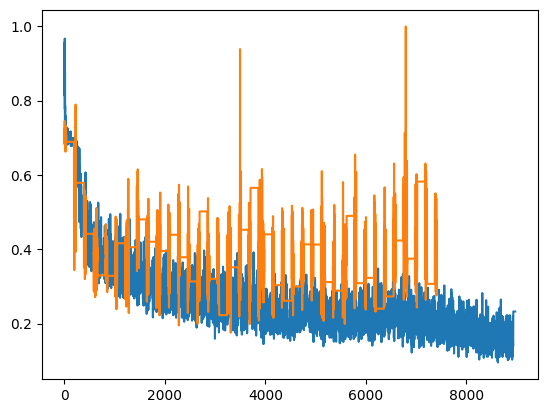

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)

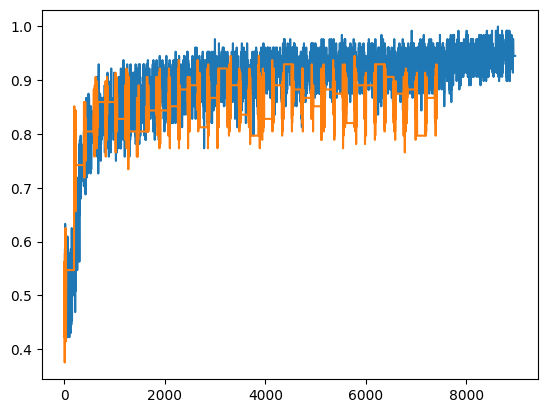

In [ ]:
plt.plot(train_accs)
plt.plot(valid_accs)

In [ ]:
sx = sx.to(device)
sy = sy.to(device)

In [ ]:
sx.shape

torch.Size([64, 278])

In [ ]:
uu = net.embs(sx)

In [ ]:
uu.shape

torch.Size([64, 278, 400])

In [ ]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model = 400, nhead =8, dim_feedforward = 2048, batch_first = True)

transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers = 2,
        )

In [ ]:
a = torch.randn(128, 278, 400)

In [ ]:
yhat = transformer_encoder(a)

In [ ]:
yhat.shape

torch.Size([128, 278, 400])

In [ ]:
lin1 = nn.Linear(400, 1)

In [ ]:
l1 = lin1(yhat)

In [ ]:
l1.shape

torch.Size([128, 278, 1])

In [ ]:
l1.view(-1, 278).shape

torch.Size([128, 278])

In [ ]:
nn.BatchNorm1d(278)(l1).shape

torch.Size([128, 278, 64])

In [ ]:
Transformer = ClassificationTransformer(emb_dropout = 0.5, dropout = 0.5, num_layers = 6).to(device)

In [ ]:
databunch = DataBunch(train_loader, valid_loader)

In [ ]:
learn = Learner(databunch, Transformer, metrics = accuracy)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


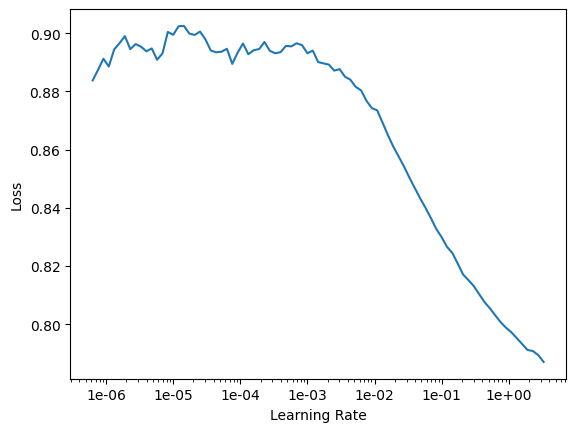

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr = 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.700914,0.974536,0.504200,00:50
1,0.694061,0.696077,0.504200,00:50


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


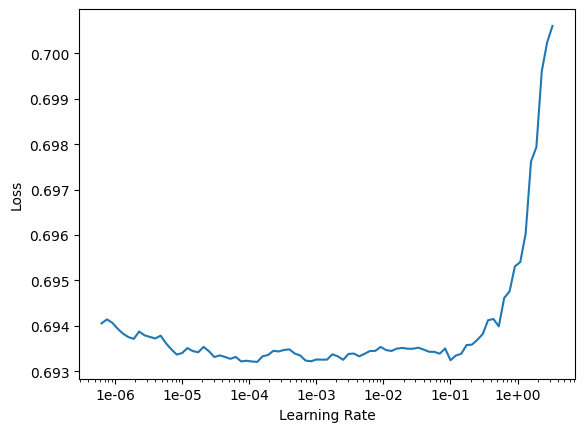

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr = 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.693238,0.697397,0.504200,00:51
1,0.693154,0.696221,0.504200,00:50
2,0.693409,0.694823,0.504200,00:50
3,0.693314,0.693596,0.504200,00:51
4,0.693017,0.693514,0.504200,00:51
